In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import captum.attr as attrMethods
from skimage.transform import resize as skim_resize
import os

os.sys.path.append(os.path.dirname(os.path.abspath('.')))

from util import model_utils
from util.attribution_methods import saliencyMethods as attr
from util.attribution_methods import GIGBuilder as GIG_Builder
from util.attribution_methods import AGI as AGI
from util.test_methods import MASTestFunctions as MAS
from util.test_methods import RISETestFunctions as RISE
from util.test_methods import PICTestFunctions as PIC
from util.modified_models import resnet
from util.visualization import attr_to_subplot

device = "cuda:0"

model = models.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
model = model.eval()
model.to(device)

modified_model = resnet.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
modified_model = modified_model.eval()
modified_model.to(device)

img_hw = 224

# transform data into format needed for model model model expects 224x224 3-color image
transform = transforms.Compose([
     transforms.Resize((img_hw, img_hw)),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

normalize = transforms.Normalize(
    (0.485, 0.456, 0.406),
    (0.229, 0.224, 0.225)
)

# invert standard ImageNet normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

resize = transforms.Resize((img_hw, img_hw))
crop = transforms.CenterCrop(img_hw)

In [2]:
random_mask = PIC.generate_random_mask(img_hw, img_hw, .01)

saliency_thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.13, 0.21, 0.34, 0.5, 0.75]

def SIC_test(img_test, saliency_map):   
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    sic_score = PIC.compute_pic_metric(img_test, saliency_map, random_mask, saliency_thresholds, 0, model, device)
    return sic_score.auc

def AIC_test(img_test, saliency_map):   
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    aic_score = PIC.compute_pic_metric(img_test, saliency_map, random_mask, saliency_thresholds, 1, model, device)
    return aic_score.auc

klen = 11
ksig = 11
kern = RISE.gkern(klen, ksig)
blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)

insertion = RISE.CausalMetric(model, img_hw * img_hw, 'ins', img_hw, substrate_fn = blur)
deletion = RISE.CausalMetric(model, img_hw * img_hw, 'del', img_hw, substrate_fn = torch.zeros_like)

def ins_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    steps, ins = insertion.single_run(img_tensor, saliency_map_test, device)

    return RISE.auc(ins)

def del_test(img_tensor, saliency_map):
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    steps, delete = deletion.single_run(img_tensor, saliency_map, device)

    return RISE.auc(delete)

# new_insertion = MAS.MASMetric(model, img_hw * img_hw, 'ins', int(img_hw**2/20), substrate_fn = blur)
# new_deletion = MAS.MASMetric(model, img_hw * img_hw, 'del',  int(img_hw**2/20), substrate_fn = torch.zeros_like)

new_insertion = MAS.MASMetric(model, img_hw * img_hw, 'ins', img_hw, substrate_fn = blur)
new_deletion = MAS.MASMetric(model, img_hw * img_hw, 'del',  img_hw, substrate_fn = torch.zeros_like)

def new_ins_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    steps, corrected_score, error, density, raw_score = new_insertion.single_run(img_tensor, saliency_map_test, device)

    x = np.linspace(0, 100, steps)

    # plt.rcParams.update({'font.size': 30})
    # plt.figure(figsize = (10, 4))
    # plt.title("MAS Model Response")
    # plt.ylabel("Response")
    # plt.xlabel("Perturbation Percentage")
    # plt.plot(x, raw_score, linewidth = 5, ls = "dashdot")
    # plt.show()

    raw_score = (raw_score - raw_score.min()) / (raw_score.max() - raw_score.min())

    print(RISE.auc(raw_score))

    plt.rcParams.update({'font.size': 30})
    plt.figure(figsize = (8, 4))
    plt.title("Model Response")
    plt.ylabel("Response")
    plt.xlabel("Perturbation Percentage")
    plt.plot(x, raw_score, linewidth = 5)
    plt.fill_between(x, np.zeros((steps)), raw_score, alpha=0.2)
    plt.show()


    plt.figure(figsize = (8, 4))
    plt.title("Density Response")
    plt.ylabel("Response")
    plt.xlabel("Perturbation Percentage")
    plt.plot(x, density, linewidth = 5, color = "green")
    plt.fill_between(x, np.zeros((steps)), density, color = "green", alpha=0.2)
    plt.show()



    # plt.rcParams.update({'font.size': 30})
    # plt.figure(figsize = (14, 8))
    # plt.title("MAS Alignment Penalty")
    # plt.ylabel("Response")
    # plt.xlabel("Perturbation Percentage")
    # plt.plot(x, raw_score, label = "Model Response", linewidth = 5, ls = "dashdot")
    # plt.plot(x, density, label = "Density Response", linewidth = 5, color = "green")
    # plt.fill_between(x, density, raw_score, label = "Alignment Penalty", color = "red", alpha=0.2)
    # plt.legend()
    # plt.show()


    # plt.rcParams.update({'font.size': 30})
    # plt.figure(figsize = (8, 8))
    # plt.title("MR and DR Derivative")
    # plt.ylabel("Response Derivative")
    # plt.xlabel("Perturbation Percentage")

    # raw_score_deriv = (raw_score[1:] - raw_score[0:-1])
    # raw_score_deriv = np.insert(raw_score_deriv, 0, 0)

    # density_deriv = (density[1:] - density[0:-1])
    # density_deriv = np.insert(density_deriv, 0, 0)

    # plt.plot(x, raw_score_deriv, label = "MR'", linewidth = 5, ls = "dashdot")
    # plt.plot(x, density_deriv, label = "DR'", linewidth = 5, color = "green")
    # plt.legend()
    # plt.show()


    # plt.rcParams.update({'font.size': 30})
    # plt.figure(figsize = (8, 8))
    # plt.title("Attribution Penalty")
    # plt.ylabel("Response ")
    # plt.xlabel("Perturbation Percentage")
    # AP = (raw_score - density)
    # plt.plot(x, AP, linewidth = 5, color = "red")
    # plt.show()


    # plt.rcParams.update({'font.size': 30})
    # plt.figure(figsize = (8, 8))
    # plt.title("AP Derivative")
    # plt.ylabel("Response Derivative")
    # plt.xlabel("Perturbation Percentage")
    # AP = (raw_score - density)
    # AP_deriv = (AP[1:] - AP[0:-1])
    # AP_deriv = np.insert(AP_deriv, 0, 0)
    # plt.plot(x, AP_deriv, linewidth = 5, color = "red")
    # plt.show()



    # plt.rcParams.update({'font.size': 35})
    # plt.figure(figsize = (8, 8))
    # plt.title("MAS Insertion Test")
    # plt.ylabel("Response")
    # plt.xlabel("Perturbation Percentage")
    # plt.plot(x, raw_score, label = "MR", linewidth = 4, ls = "dashdot")
    # plt.plot(x, density, label = "DR", linewidth = 4, color = "green")
    # plt.fill_between(x, density, raw_score, label = "AP", color = "red", alpha=0.2)
    # # plt.plot(x, error, label = "AP", linewidth = 4, color = "red", ls = "dashed")
    # # plt.plot(x, corrected_score, label = "MAS Ins", linewidth = 4, color = "purple", ls = "solid")
    # plt.legend()
    # plt.show()

    return MAS.auc(corrected_score)


def new_del_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    steps, corrected_score, error, density, raw_score = new_deletion.single_run(img_tensor, saliency_map_test, device)

    # plt.rcParams.update({'font.size': 35})
    # plt.figure(figsize = (8, 8))
    # plt.title("MAS Deletion Test")
    # plt.ylabel("Model Output")
    # plt.xlabel("Perturbation Step")
    # plt.plot(np.linspace(0, steps, steps), raw_score, label = "SROC", linewidth = 3)
    # plt.plot(np.linspace(0, steps, steps), density, label = "DROC", linewidth = 3, color = "orange")
    # plt.legend()
    # plt.show()

    # plt.rcParams.update({'font.size': 35})
    # plt.figure(figsize = (8, 8))
    # plt.title("MAS Deletion Test")
    # plt.ylabel("Model Output")
    # plt.xlabel("Perturbation Step")
    # plt.plot(np.linspace(0, steps, steps), raw_score, label = "SROC", linewidth = 3)
    # plt.plot(np.linspace(0, steps, steps), error, label = "PROC", linewidth = 3, color = "red")
    # plt.legend()
    # plt.show()

    # plt.rcParams.update({'font.size': 35})
    # plt.figure(figsize = (8, 8))
    # plt.title("MAS Deletion Test")
    # plt.ylabel("Response")
    # plt.xlabel("Perturbation Step")
    # plt.plot(np.linspace(0, steps, steps), error, label = "DE", linewidth = 3, color = "red")
    # plt.plot(np.linspace(0, steps, steps), corrected_score, label = "MAS Ins", linewidth = 3, color = "purple")
    # plt.legend()
    # plt.show()

    plt.rcParams.update({'font.size': 35})
    plt.figure(figsize = (8, 8))
    plt.title("MAS Insertion Test")
    plt.ylabel("Model Output")
    plt.xlabel("Perturbation Step")
    plt.plot(np.linspace(0, steps, steps), raw_score, label = "MR", linewidth = 3, ls = "dashdot")
    # plt.fill_between(np.linspace(0, steps, steps), density, raw_score, label = "DE", color = "red", alpha=0.2)
    plt.plot(np.linspace(0, steps, steps), error, label = "DE", linewidth = 3, color = "red", ls = "dashed")
    # plt.plot(np.linspace(0, steps, steps), density, label = "DR", linewidth = 3, color = "green")
    plt.plot(np.linspace(0, steps, steps), corrected_score, label = "MAS Ins", linewidth = 3, color = "purple", ls = "solid")
    plt.legend()
    plt.show()

    # return NM.auc(raw_score), NM.auc(error), NM.auc(corrected_score) 
    # return NM.auc(raw_score), NM.auc(corrected_score)
    return MAS.auc(corrected_score)

In [3]:
import os 
# 623, 12, 13, 102, 369, 228, 5026, 53
# jet 7004
# Compass - small_objects_50 455
# bird 414

image_path = "../../ImageNet/ILSVRC2012_val_00010641.JPEG"
# # image_path = "../small_objects_25/ILSVRC2012_val_00003064.JPEG"
# # image_path = "/Users/chase/Desktop/ImageNet/ILSVRC2012_img_val/ILSVRC2012_val_00007004.JPEG"
# # image_path = "../img/banana.jpg"

# # path = "../imagenet"
# # path = "../small_objects_25"
# path = "../small_objects_50"

# images = os.listdir(path)
# print(len(images))
# image_path = path + "/" + images[455]

80.07969260215759


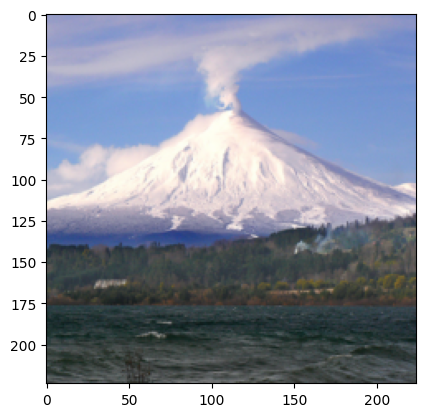

In [4]:
########  IG  LIG,  IDG  ########
img = Image.open(image_path)
img = transform(img)

# put the image in form needed for prediction for the ins/del method
img_tensor = transform_normalize(img)
img_tensor_IG_LIG_IDG = torch.unsqueeze(img_tensor, 0)

target_class = model_utils.getClass(img_tensor_IG_LIG_IDG, model, device)

print(model_utils.getPrediction(img_tensor_IG_LIG_IDG, model, device, target_class)[0] * 100)

plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

########  IG  ########
ig = attr.IG(img_tensor_IG_LIG_IDG, model, 50, 50, 1, 0, device, target_class)
ig = np.transpose(ig.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  LIG  ########
lig = attr.IG(img_tensor_IG_LIG_IDG, model, 50, 50, .9, 0, device, target_class)
lig = np.transpose(lig.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  IDG  ########
idg = attr.IDG(img_tensor_IG_LIG_IDG, model, 50, 50, 0, device, target_class)
idg = np.transpose(idg.squeeze().detach().cpu().numpy(), (1, 2, 0))

# image for AIC/SIC test
AIC_img = np.transpose(img.squeeze().detach().numpy(), (1, 2, 0))

In [5]:
######## GC, GGC, GBP ########

#### GC ####
layer = model.layer4
# layer = model.conv_proj

layer_gc = attrMethods.LayerGradCam(model, layer)
img_tensor_IG_LIG_IDG.requires_grad = True
gc = layer_gc.attribute(img_tensor_IG_LIG_IDG.to("cuda:0"),  target_class, relu_attributions=True)
torch.cuda.empty_cache()
gc = skim_resize(gc.squeeze().cpu().detach().numpy(), (224, 224), preserve_range=True)
gc = torch.tensor(gc).reshape((1, 224, 224)) * torch.ones((3, 224, 224))
gc = np.transpose(gc.squeeze().detach().cpu().numpy(), (1, 2, 0))

#### GGC ####
guided_gc = attrMethods.GuidedGradCam(modified_model, modified_model.layer4)
# guided_gc = attrMethods.GuidedGradCam(modified_model, modified_model.conv_proj)
ggc = guided_gc.attribute(img_tensor_IG_LIG_IDG.to("cuda:0"), target_class)
ggc = np.transpose(ggc.squeeze().detach().cpu().numpy(), (1, 2, 0))

#### GBP ####
guided_bp = attrMethods.GuidedBackprop(modified_model)
gbp = guided_bp.attribute(img_tensor_IG_LIG_IDG.to("cuda:0"), target = target_class)
gbp = np.transpose(gbp.squeeze().detach().cpu().numpy(), (1, 2, 0))

img_tensor_IG_LIG_IDG.requires_grad = False

/home/chasewalker/.local/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [6]:
########  AGI  ########
def threshold(saliency_map, lowerbound = 80, upperbound = 99, img_hw = 224):
    hm = saliency_map
    hm = np.mean(hm, axis=0)
    l = np.percentile(hm, lowerbound)
    u = np.percentile(hm, upperbound)
    
    hm[hm < l] = l
    hm[hm > u] = u
    hm = (hm - l)/(u - l)

    saliency_map = np.reshape(hm, (img_hw, img_hw, 1))
    
    return saliency_map

# set up new AGI model
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_layer = AGI.Normalize(mean, std)
AGI_model = nn.Sequential(norm_layer, model).to(device)

epsilon = 0.05
max_iter = 20
topk = 1
# define the ids of the selected adversarial class
selected_ids = range(0, 999, int(1000 / topk)) 

agi_img = AGI.LoadImage(image_path, resize, crop)
agi_img = agi_img.astype(np.float32) 

# Run test
example = AGI.test(AGI_model, device, agi_img, epsilon, topk, selected_ids, max_iter)
agi = example[2]

agi_n = np.transpose(agi, (1, 2, 0))
agi_t = threshold(agi)

img_tensor = torch.tensor(np.transpose(agi_img / 255, (2, 0, 1)))
img_tensor = torch.unsqueeze(img_tensor, 0)
img_tensor_AGI = transform_normalize(img_tensor)

In [7]:
agi = agi_t

In [8]:
def score_print(RISE_img, AIC_img, attr):
    # AIC = AIC_test(AIC_img, attr)
    SIC = SIC_test(AIC_img, attr)
    # ins = ins_test(RISE_img, attr)
    # delete = del_test(RISE_img, attr)
    # new_ins = new_ins_test(RISE_img, attr)
    # new_delete = new_del_test(RISE_img, attr)

    # return "Density Ins: " + str(round(new_ins, 3)) + "\nDensity Del: " + str(round(new_delete, 3)) + "\n"

    # return "Ins: " + str(round(ins, 3)) + " Del: " + str(round(delete, 3)) + "\nnew_ins: " + str(round(new_ins, 3)) + " new_del: " + str(round(new_delete, 3)) + "\n"
 
    # return " RISE Ins: " + str(round(ins, 3)) + "\nSIC: " + str(round(SIC, 3)) + "\n"
    # return " RISE Ins: " + str(round(ins, 3)) + "\n"
    # return " RISE Del: " + str(round(delete, 3)) + "\n"
    return "SIC: " + str(round(SIC, 3)) + "\n"
    # return "AIC: " + str(round(AIC, 3)) + "\n"



    # return "RISE Ins: " + str(round(ins, 3)) + "\nRISE Del: " + str(round(delete, 3)) + "\nSIC: " + str(round(SIC, 3)) + "\nAIC: " + str(round(AIC, 3)) + "\nnew_ins: " + str(round(new_ins, 3)) + "\nnew_del: " + str(round(new_delete, 3)) + "\n"

In [9]:
def print_maps(saliency_map, img_hw, num_steps, num_to_show = 19):
    step_size = int(img_hw ** 2 / num_steps)
    steps = num_to_show

    norm = "absolute"
    cols = 10
    rows = int((steps + 1) / cols) + (1 if (steps + 1) % cols != 0 else 0)

    row = 0
    col = 1

    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(rows, cols, figsize = (23, 3 * rows))

    attr_to_subplot(saliency_map, "Attribution", axs[0, 0], norm = norm)

    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    # normalize the saliency map to (0, 1)
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
    # Coordinates of pixels in order of decreasing saliency
    salient_order = np.flip(np.argsort(saliency_map.reshape(-1, img_hw * img_hw), axis = 1), axis = -1)


    for i in range(steps):
        map = np.zeros_like(saliency_map)
        coords = salient_order[:, step_size * i : step_size * (i + 1)]
        map.reshape(1, 1, img_hw * img_hw)[0, :, coords] = saliency_map.reshape(1, 1, img_hw * img_hw)[0, :, coords]

        map = np.reshape(map, (img_hw, img_hw, 1))

        if col == cols:
            col = 0
            row += 1

        attr_to_subplot(map, "Step " + str(i + 1), axs[row, col], norm = norm)

        col += 1

    for i in range(cols - col):
        map = np.zeros_like(saliency_map)
        map = np.reshape(map, (img_hw, img_hw, 1))

        attr_to_subplot(map, "NONE", axs[row, col + i], norm = norm)

    fig.tight_layout()

/home/chasewalker/Desktop/XAIcode/code_new/util/visualization.py:5: RuntimeWarning: invalid value encountered in divide
  attr_norm = attr / scale_factor


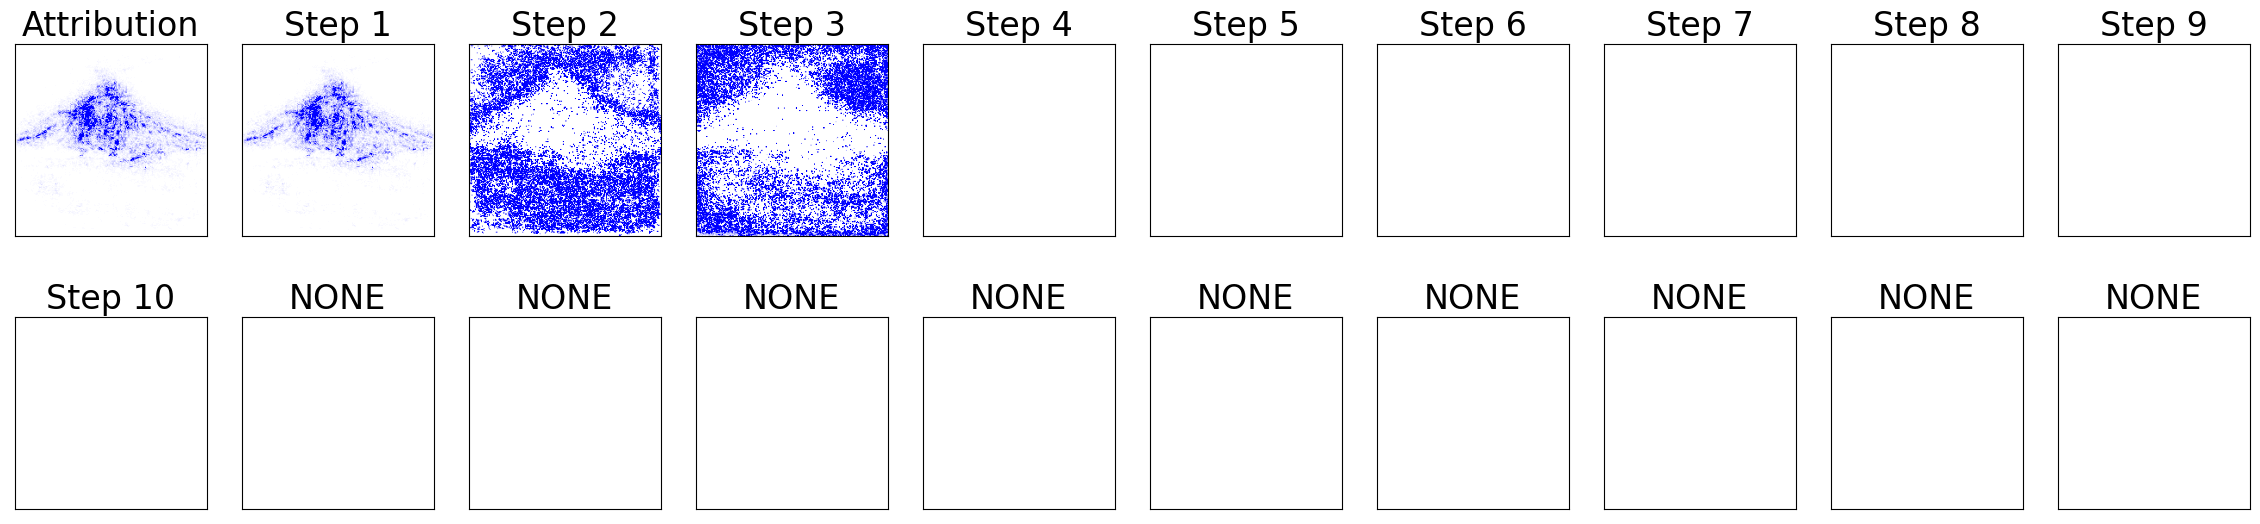

In [10]:
print_maps(idg, 224, 3, 10)

In [25]:
def perc(orig, new):
    return 100 * np.ans(orig - new) / orig

def compare(attr, attr_1, attr_0, RISE_img, AIC_img):
    # saliency_map_test = np.abs(np.sum(attr, axis = 2))
    # saliency_map_test_1 = np.abs(np.sum(attr_1, axis = 2))
    # saliency_map_test_0 = np.abs(np.sum(attr_0, axis = 2))
    

    saliency_map_test = attr
    saliency_map_test_1 = attr_1
    saliency_map_test_0 = attr_0

    plt.rcParams.update({'font.size': 15})
    fig, axs = plt.subplots(1, 6, figsize = (36, 6))


    # sic_score = XRAI.compute_pic_metric(AIC_img, saliency_map_test, random_mask, saliency_thresholds, 0, model, device)
    # sic_score_1 = XRAI.compute_pic_metric(AIC_img, saliency_map_test_1, random_mask, saliency_thresholds, 0, model, device)
    # sic_score_0 = XRAI.compute_pic_metric(AIC_img, saliency_map_test_0, random_mask, saliency_thresholds, 0, model, device)
    # dist = round(np.mean((np.abs(sic_score.curve_y - sic_score_1.curve_y) + np.abs((sic_score.curve_y - sic_score_0.curve_y))) / 2), 3)
    # axs[0].set_title("SIC, dist = " + str(dist))
    # axs[0].plot(sic_score.curve_x, sic_score.curve_y, label = "Original", linewidth = 3)
    # axs[0].plot(sic_score_1.curve_x, sic_score_1.curve_y, label = "Add", linewidth = 3)
    # axs[0].plot(sic_score_0.curve_x, sic_score_0.curve_y, label = "Remove", linewidth = 3)
    # axs[0].legend()


    # aic_score = XRAI.compute_pic_metric(AIC_img, saliency_map_test, random_mask, saliency_thresholds, 1, model, device)
    # aic_score_1 = XRAI.compute_pic_metric(AIC_img, saliency_map_test_1, random_mask, saliency_thresholds, 1, model, device)
    # aic_score_0 = XRAI.compute_pic_metric(AIC_img, saliency_map_test_0, random_mask, saliency_thresholds, 1, model, device)
    # dist = round(np.mean((np.abs(aic_score.curve_y - aic_score_1.curve_y) + np.abs((aic_score.curve_y - aic_score_0.curve_y))) / 2), 3)
    # axs[1].set_title("AIC, dist = " + str(dist))
    # axs[1].plot(aic_score.curve_x, aic_score.curve_y, label = "Original", linewidth = 3)
    # axs[1].plot(aic_score_1.curve_x, aic_score_1.curve_y, label = "Add", linewidth = 3)
    # axs[1].plot(aic_score_0.curve_x, aic_score_0.curve_y, label = "Remove", linewidth = 3)
    # axs[1].legend()



    steps, corrected_score, _, density, score = new_insertion.single_run(RISE_img, saliency_map_test, device, max_batch_size=10)
    steps, corrected_score_1, _, density_1, score_1 = new_insertion.single_run(RISE_img, saliency_map_test_1, device, max_batch_size=10)
    steps, corrected_score_0, _, _, score_0 = new_insertion.single_run(RISE_img, saliency_map_test_0, device, max_batch_size=10)

    dist = round(np.mean((np.abs(score - score_1) + np.abs((score - score_0))) / 2), 3)
    perc_diff = dist / MAS.auc(score) * 100
    x = np.linspace(0, steps, steps)
    axs[2].set_title("ins, dist = " + str(perc_diff))
    axs[2].plot(x, score, label = "Original", linewidth = 3)
    axs[2].plot(x, score_1, label = "Add", linewidth = 3)
    axs[2].plot(x, score_0, label = "Add More", linewidth = 3)
    axs[2].legend()

    print("RISE INS: ", str(MAS.auc(score)), str(MAS.auc(score_1)), str(MAS.auc(score_0)))
    print("MAS INS: ", str(MAS.auc(corrected_score)), str(MAS.auc(corrected_score_1)), str(MAS.auc(corrected_score_0)))

    dist = round(np.mean((np.abs(corrected_score - corrected_score_1) + np.abs((corrected_score - corrected_score_0))) / 2), 3)
    perc_diff = dist / MAS.auc(corrected_score) * 100
    x = np.linspace(0, steps, steps)
    axs[4].set_title("ins new, dist = " + str(perc_diff))
    axs[4].plot(x, corrected_score, label = "Original", linewidth = 3)
    # axs[4].plot(x, density, label = "Density", linewidth = 3)
    axs[4].plot(x, corrected_score_1, label = "Add", linewidth = 3)
    # axs[4].plot(x, density_1, label = "Density_add", linewidth = 3)
    axs[4].plot(x, corrected_score_0, label = "Add More", linewidth = 3)
    axs[4].legend()



    steps, corrected_score, _, _, score = new_deletion.single_run(RISE_img, saliency_map_test, device, max_batch_size=10)
    steps, corrected_score_1, _, _, score_1 = new_deletion.single_run(RISE_img, saliency_map_test_1, device, max_batch_size=10)
    steps, corrected_score_0, _, _, score_0 = new_deletion.single_run(RISE_img, saliency_map_test_0, device, max_batch_size=10)

    dist = round(np.mean((np.abs(score - score_1) + np.abs((score - score_0))) / 2), 3)
    perc_diff = dist / MAS.auc(score) * 100
    x = np.linspace(0, steps, steps)
    axs[3].set_title("del, dist = " + str(perc_diff))
    axs[3].plot(x, score, label = "Original", linewidth = 3)
    axs[3].plot(x, score_1, label = "Add", linewidth = 3)
    axs[3].plot(x, score_0, label = "Add More", linewidth = 3)
    axs[3].legend()

    dist = round(np.mean((np.abs(corrected_score - corrected_score_1) + np.abs((corrected_score - corrected_score_0))) / 2), 3)
    perc_diff = dist / MAS.auc(corrected_score) * 100
    x = np.linspace(0, steps, steps)
    axs[5].set_title("del new, dist = " + str(perc_diff))
    axs[5].plot(x, corrected_score, label = "Original", linewidth = 3)
    axs[5].plot(x, corrected_score_1, label = "Add", linewidth = 3)
    axs[5].plot(x, corrected_score_0, label = "Add More", linewidth = 3)
    axs[5].legend()

    # print("RISE DEL: ", str(MAS.auc(score)), str(MAS.auc(score_1)), str(MAS.auc(score_0)))
    # print("MAS DEL: ", str(MAS.auc(corrected_score)), str(MAS.auc(corrected_score_1)), str(MAS.auc(corrected_score_0)))

    fig.tight_layout()

    return

In [60]:
def get_variations(attribution):
    five_perc = 0.05 * attribution.max() 
    ten_perc = 0.10 * attribution.max() 
    twenty_five_perc = 0.25 * attribution.max() 
    fifty_perc = 0.50 * attribution.max() 
    attr_base = np.abs(np.sum(attribution, axis = 2))

    attr_add_5  = (attr_base + five_perc)
    attr_add_10  = (attr_base + ten_perc)
    attr_add_25  = (attr_base + twenty_five_perc)
    attr_add_50 = (attr_base + fifty_perc)

    # attr_add_5  = (attr_base * 2)
    # attr_add_10  = (attr_base * 2)
    # attr_add_25  = (attr_base * 2)
    # attr_add_50 = (attr_base * 2)

    return [attr_base, attr_add_5, attr_add_10, attr_add_25, attr_add_50]

1.0
0.9896564094387755
0.9793925382653061


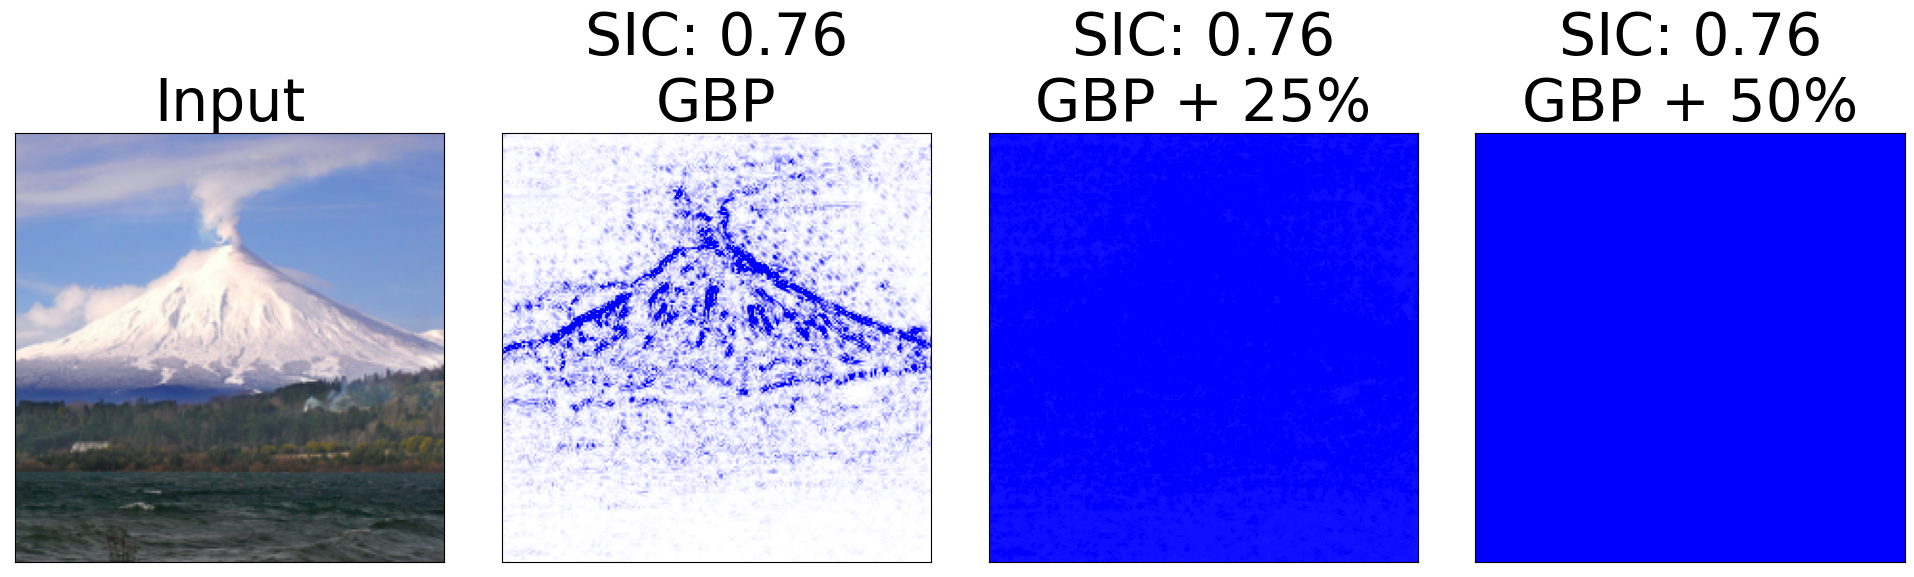

In [74]:
sel_attr = gbp
variations = get_variations(sel_attr)

attr_base = variations[0]
attr_add = variations[3]
attr_minus = variations[4]

salient_order_1 = np.flip(np.argsort(attr_base.reshape(224 ** 2), axis = 0), axis = -1)
salient_order_2 = np.flip(np.argsort(attr_add.reshape(224 ** 2), axis = 0), axis = -1)
salient_order_3 = np.flip(np.argsort(attr_minus.reshape(224 ** 2), axis = 0), axis = -1)

print(np.mean(salient_order_1 == salient_order_1))
print(np.mean(salient_order_1 == salient_order_2))
print(np.mean(salient_order_1 == salient_order_3))

plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(1, 4, figsize = (20, 7))

norm = "absolute"

steps, corrected_score, _, density, score = new_insertion.single_run(img_tensor_IG_LIG_IDG, attr_base, device, max_batch_size=10)
steps, corrected_score_1, _, density_1, score_1 = new_insertion.single_run(img_tensor_IG_LIG_IDG, attr_add, device, max_batch_size=10)
steps, corrected_score_0, _, _, score_0 = new_insertion.single_run(img_tensor_IG_LIG_IDG, attr_minus, device, max_batch_size=10)

attr_to_subplot(img, "Input", axs[0], original_image=True)
attr_to_subplot(attr_base.reshape(224, 224, 1),  "SIC: " + str(round(RISE.auc(score), 3)) + "\nGBP", axs[1], norm = norm)
attr_to_subplot(attr_add.reshape(224, 224, 1), "SIC: " + str(round(RISE.auc(score_1), 3)) + "\nGBP + 25%", axs[2], norm = norm)
attr_to_subplot(attr_minus.reshape(224, 224, 1), "SIC: " + str(round(RISE.auc(score_0), 3)) + "\nGBP + 50%", axs[3], norm = norm)

fig.tight_layout()
plt.savefig("offset.png", bbox_inches='tight', transparent=True, pad_inches=0)
# plt.close(fig)

RISE INS:  0.7597932250105909 0.7597939370732222 0.759796930343977
MAS INS:  0.8440520187057274 0.5665390356447012 0.5368310733309757


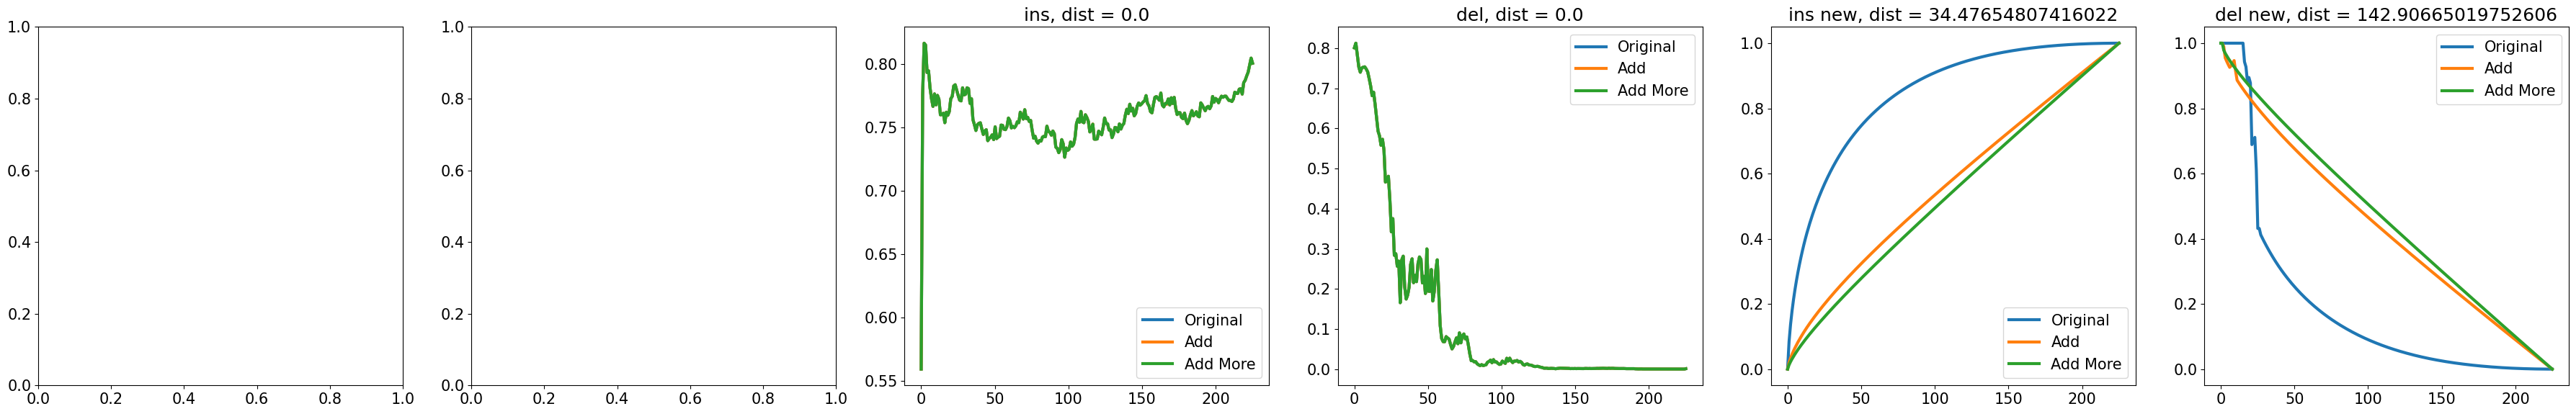

In [62]:
compare(attr_base, attr_add, attr_minus, img_tensor_IG_LIG_IDG, AIC_img)

In [63]:
# sel_attr_scores = score_print(img_tensor_IG_LIG_IDG, AIC_img, sel_attr)
# attr_add_scores = score_print(img_tensor_IG_LIG_IDG, AIC_img, attr_add)
# attr_minus_scores = score_print(img_tensor_IG_LIG_IDG, AIC_img, attr_minus)

In [64]:
# plt.rcParams.update({'font.size': 35})
# fig, axs = plt.subplots(1, 4, figsize = (20, 7))

# norm = "absolute"

# attr_to_subplot(img, "Input", axs[0], original_image=True)
# attr_to_subplot(sel_attr, sel_attr_scores + "GBP", axs[1], norm = norm)
# attr_to_subplot(attr_add, attr_add_scores + "GBP", axs[2], norm = norm)
# attr_to_subplot(attr_minus, attr_minus_scores + "GBP", axs[3], norm = norm)

# fig.tight_layout()

In [65]:
# scores_1 = score_print(img_tensor_IG_LIG_IDG, AIC_img, lig)
# scores_2 = score_print(img_tensor_IG_LIG_IDG, AIC_img, gbp)

In [66]:
# plt.rcParams.update({'font.size': 35})
# fig, axs = plt.subplots(1, 3, figsize = (15, 7))

# norm = "absolute"

# attr_to_subplot(img, "Input", axs[0], original_image=True)
# attr_to_subplot(lig, scores_1 + "LIG", axs[1], norm = norm)
# attr_to_subplot(gbp, scores_2 + "GBP", axs[2], norm = norm)

# fig.tight_layout()

0.8689185612572566


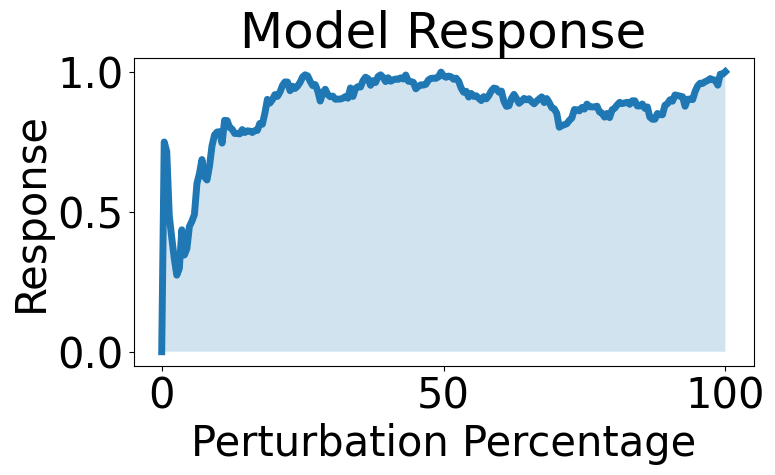

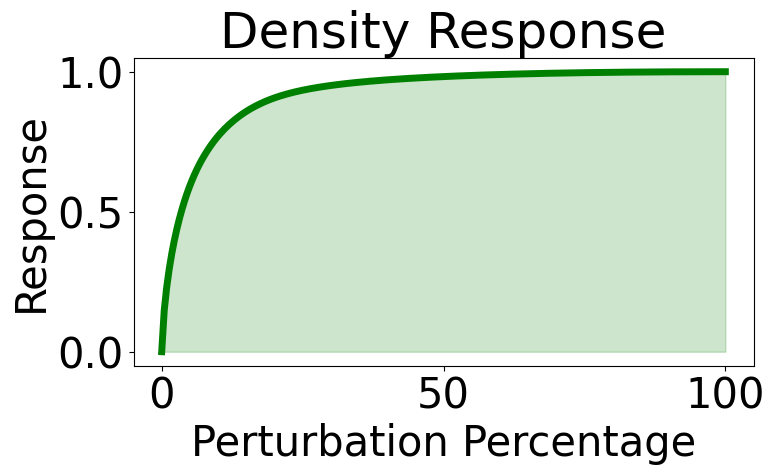

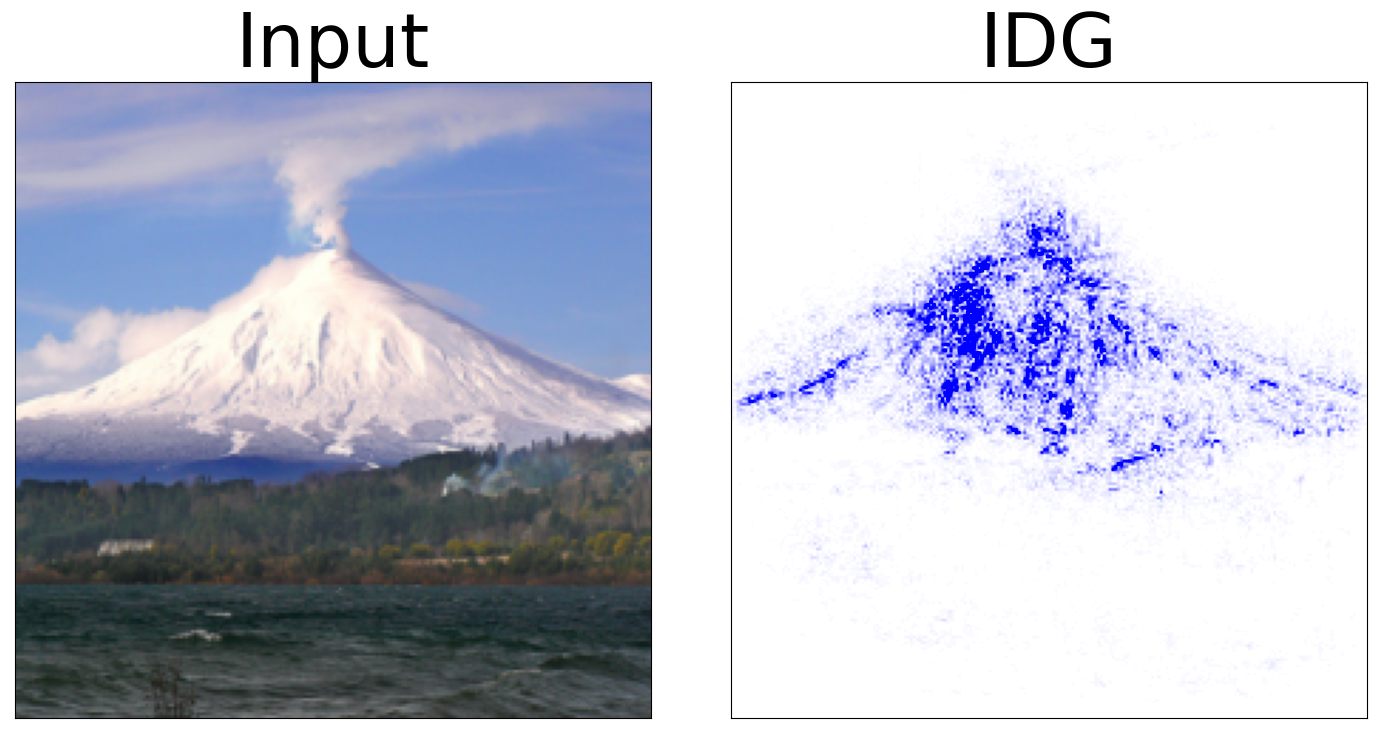

In [67]:
def score_print_1(RISE_img, attr):
    # new_delete = new_del_test(RISE_img, attr)
    # return "MAS Del: " + str(round(new_delete, 3)) + "\n"

    new_ins = new_ins_test(RISE_img, attr)
    return "MAS Ins: " + str(round(new_ins, 3)) + "\n"

scores_1 = score_print_1(img_tensor_IG_LIG_IDG, idg)
# scores_2 = score_print_1(img_tensor_IG_LIG_IDG, gbp)
# scores_1 = score_print_1(img_tensor_IG_LIG_IDG, gc)
# scores_2 = score_print_1(img_tensor_IG_LIG_IDG, ggc)

plt.rcParams.update({'font.size': 45})
fig, axs = plt.subplots(1, 2, figsize = (15, 8))

norm = "absolute"

attr_to_subplot(img, "Input", axs[0], original_image=True)
attr_to_subplot(idg, "IDG", axs[1], norm = norm)
# attr_to_subplot(gbp, scores_2 + "GBP", axs[1], norm = norm)

fig.tight_layout()